In [ ]:
# -*- coding: utf-8 -*-
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import re
import numpy as np
import unicodedata as ud

# ===== RUTAS =====
# 0) Montar Drive (Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

DIR_MINUTOS = Path("/content/drive/MyDrive/Sport Data Campus/TFM/Minutos/")
OUT_DIR     = DIR_MINUTOS / "_salidas_minutos"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ===== PATRONES =====
RE_FECHA_RIVAL = re.compile(
    r"Fecha\s*(?:N[º°o]\.?\s*)?(\d+)\s*-\s*(.+?)\s*-\s*XML\s*TotalValues",
    re.IGNORECASE | re.UNICODE
)
NAME_ROLE_RE   = re.compile(r"^\s*([^(]+?)\s*\(([^)]+)\)")

# ===== DESCRIPCIONES =====
# Relevantes (normalizadas)
HARD_LABELS = {
    "goles a favor en cancha": "gf_on",
    "gol rival en cancha": "ga_on",
    "participa en gol hecho": "part_gf",
    "involucrado en gol recibido": "invol_ga",
    "valla invicta en cancha": "valla",
}
# Etiquetas que se deben IGNORAR para decidir si la instancia está "vacía"
IGNORABLE_LABELS = {"total"}  # se pueden agregar más si hace falta

# ===== Helpers =====
def _norm_txt(t: str) -> str:
    if not t: return ""
    t = ud.normalize('NFKD', t).encode('ascii', 'ignore').decode('ascii')
    return re.sub(r"\s+", " ", t.strip().lower())

def _parse_fecha_rival(path: Path):
    m = RE_FECHA_RIVAL.search(path.stem)
    if m:
        fecha = int(m.group(1))
        rival = m.group(2).strip()
        return fecha, rival, f"F{fecha}_{rival}"
    return None, path.stem, path.stem

def _merge_intervals(intervals):
    if not intervals: return []
    ints = []
    for s, e in intervals:
        try:
            s = float(s); e = float(e)
        except:
            continue
        if e <= s: e = s + 0.04
        ints.append((s, e))
    ints.sort()
    merged = [list(ints[0])]
    for s, e in ints[1:]:
        if s <= merged[-1][1]:
            merged[-1][1] = max(merged[-1][1], e)
        else:
            merged.append([s, e])
    return [(s, e) for s, e in merged]

def _format_mmss(seconds):
    s = int(round(float(seconds)))
    mm, ss = divmod(s, 60)
    return f"{mm:02d}:{ss:02d}"

def _labels_from_instance(inst):
    """
    Lee textos en <label><text> ... (estructura típica en tus XML).
    Devuelve dos listas:
      - labels_norm: todos los labels normalizados
      - labels_decision: labels normalizados tras eliminar 'ignorables'
    """
    labels = []
    for lab in inst.findall("./label"):
        txt = lab.findtext("text")
        if isinstance(txt, str) and txt.strip():
            labels.append(_norm_txt(txt))
    labels = [x for x in labels if x]  # limpia vacíos

    # Para decidir inclusión tratamos algunos labels como "no cuentan" (ej. 'total')
    labels_decision = [x for x in labels if x not in IGNORABLE_LABELS]
    return labels, labels_decision

# ===== Núcleo =====
def minutos_y_incidencias_por_archivo(xml_path: Path):
    fecha, rival, partido_id = _parse_fecha_rival(xml_path)
    root = ET.parse(xml_path).getroot()

    agg = {}  # (nombre, rol) -> acumuladores

    for inst in root.findall(".//instance"):
        # tiempos
        s = inst.findtext("start"); e = inst.findtext("end")
        try:
            s = float(s); e = float(e)
        except:
            continue
        if e <= s: e = s + 0.04

        # jugador (rol)
        code = inst.findtext("code") or ""
        m = NAME_ROLE_RE.match(code)
        if not m:
            continue
        nombre = m.group(1).strip()
        rol    = m.group(2).strip()

        # labels
        labels_all, labels_decision = _labels_from_instance(inst)

        # Regla de inclusión:
        #  - INCLUIR si tiene >=1 relevante (en labels_all)
        #  - INCLUIR si, tras filtrar ignorables, NO queda ningún label (instancia "vacía")
        #  - EXCLUIR si solo hay labels NO relevantes (y no está vacía tras el filtro)
        has_relevant = any(l in HARD_LABELS for l in labels_all)
        is_empty_after_ignoring = (len(labels_decision) == 0)

        incluir = has_relevant or is_empty_after_ignoring
        if not incluir:
            continue

        # Contar incidencias (todas las repeticiones de las 5 relevantes)
        counts = {k:0 for k in HARD_LABELS.values()}
        for l in labels_all:
            if l in HARD_LABELS:
                counts[HARD_LABELS[l]] += 1

        key = (nombre, rol)
        if key not in agg:
            agg[key] = {
                "intervals": [],
                "gf":0, "ga":0, "part":0, "invol":0, "valla":0
            }
        a = agg[key]
        a["intervals"].append((s, e))
        a["gf"]    += counts["gf_on"]
        a["ga"]    += counts["ga_on"]
        a["part"]  += counts["part_gf"]
        a["invol"] += counts["invol_ga"]
        a["valla"] += counts["valla"]

    # Construcción por ROL
    rows_rol = []
    for (nombre, rol), a in agg.items():
        merged = _merge_intervals(a["intervals"])
        segundos = sum(e - s for s, e in merged)
        rows_rol.append({
            "partido_id": partido_id,
            "fecha": fecha,
            "rival": rival,
            "nombre": nombre,
            "rol": rol,
            "segundos": int(round(segundos)),
            "mmss": _format_mmss(segundos),
            "minutos": round(segundos/60.0, 2),
            "n_tramos": len(merged),
            "gf_on_count": a["gf"],
            "ga_on_count": a["ga"],
            "participa_gol_hecho_count": a["part"],
            "involuc_ga_count": a["invol"],
            "valla_invicta_count": a["valla"],
        })

    df_por_rol = pd.DataFrame(rows_rol)

    # Sumarizado a JUGADOR desde ROL (consistencia total)
    if df_por_rol.empty:
        df_por_jugador = pd.DataFrame(columns=[
            "partido_id","fecha","rival","nombre","segundos","mmss","minutos","n_tramos",
            "gf_on_count","ga_on_count","participa_gol_hecho_count","involuc_ga_count","valla_invicta_count"
        ])
    else:
        grp = (df_por_rol.groupby(["partido_id","fecha","rival","nombre"], as_index=False)
                        .agg({
                            "segundos":"sum",
                            "n_tramos":"sum",
                            "gf_on_count":"sum",
                            "ga_on_count":"sum",
                            "participa_gol_hecho_count":"sum",
                            "involuc_ga_count":"sum",
                            "valla_invicta_count":"sum"
                        }))
        grp["mmss"]   = grp["segundos"].apply(_format_mmss)
        grp["minutos"]= (grp["segundos"]/60.0).round(2)
        df_por_jugador = grp

    return df_por_rol, df_por_jugador

# ===== MAIN =====
files = sorted(DIR_MINUTOS.rglob("*.xml"))
all_rol, all_jug = [], []
for f in files:
    if "TotalValues" not in f.stem:
        continue
    try:
        df_r, df_j = minutos_y_incidencias_por_archivo(f)
        all_rol.append(df_r); all_jug.append(df_j)
    except Exception as e:
        print(f"⚠️ Error procesando {f.name}: {e}")

df_por_rol = pd.concat(all_rol, ignore_index=True) if all_rol else pd.DataFrame()
df_por_jug = pd.concat(all_jug, ignore_index=True) if all_jug else pd.DataFrame()

# Guardar
(df_por_rol.sort_values(["fecha","rival","nombre","rol"])
          .to_csv(OUT_DIR / "minutos_por_partido_rol.csv", index=False))
(df_por_jug.sort_values(["fecha","rival","nombre"])
          .to_csv(OUT_DIR / "minutos_por_partido_total.csv", index=False))

print("✅ Listo")
print(" -", OUT_DIR / "minutos_por_partido_rol.csv")
print(" -", OUT_DIR / "minutos_por_partido_total.csv")

# Chequeo rápido por partido: suma de minutos (por ROL) ≈ 40
#if not df_por_rol.empty:
#    chk = (df_por_rol.groupby(["partido_id","fecha","rival"], as_index=False)
#                    .agg(seg_tot=("segundos","sum")))
#    chk["min_tot"] = (chk["seg_tot"]/60).round(2)
#    print("\n⏱️ Suma por partido (minutos, por ROL):")
#    print(chk.sort_values(["fecha","rival"]))



✅ Listo
 - /content/drive/MyDrive/Sport Data Campus/TFM/Minutos/_salidas_minutos/minutos_por_partido_rol.csv
 - /content/drive/MyDrive/Sport Data Campus/TFM/Minutos/_salidas_minutos/minutos_por_partido_total.csv


In [ ]:
# -*- coding: utf-8 -*-
from pathlib import Path
import pandas as pd
import numpy as np

# === RUTAS (las tuyas) ===
DIR_MINUTOS = Path("/content/drive/MyDrive/Sport Data Campus/TFM/Minutos/")
OUT_DIR     = DIR_MINUTOS / "_salidas_minutos"
CSV_ROL     = OUT_DIR / "minutos_por_partido_rol.csv"

TOL_SEC = 10  # tolerancia de ±10s para considerar “ok”

def mmss(seg):
    s = int(round(seg))
    m, s = divmod(s, 60)
    return f"{m:02d}:{s:02d}"

if not CSV_ROL.exists():
    raise FileNotFoundError(f"No encuentro {CSV_ROL}")

# Cargamos tu salida por rol (NO tocamos el cálculo original)
df = pd.read_csv(CSV_ROL)

# Validaciones mínimas de columnas esperadas
cols_needed = {"partido_id","fecha","rival","rol","segundos"}
faltan = cols_needed - set(df.columns)
if faltan:
    raise ValueError(f"Faltan columnas en {CSV_ROL.name}: {faltan}")

# Sumar segundos por Partido x Rol
rol_sum = (
    df.groupby(["partido_id","fecha","rival","rol"], as_index=False)
      .agg(segundos_rol=("segundos","sum"))
      .sort_values(["fecha","rival","rol"])
)

# Métricas de control vs 40:00
rol_sum["mmss_rol"]   = rol_sum["segundos_rol"].apply(mmss)
rol_sum["delta_sec"]  = rol_sum["segundos_rol"] - 2400
rol_sum["delta_mmss"] = rol_sum["delta_sec"].apply(lambda x: ("+" if x>=0 else "-")+mmss(abs(x)))
rol_sum["ok_±tol"]    = rol_sum["delta_sec"].abs() <= TOL_SEC

print("=== Minutos por Partido x Rol (suma de todos los jugadores en ese rol) ===")
print(rol_sum.to_string(index=False))

# Resumen por partido: cuántos roles pasan el control y total acumulado de todos los roles
resumen = (
    rol_sum.groupby(["partido_id","fecha","rival"], as_index=False)
           .agg(
               roles_ok=("ok_±tol","sum"),
               # total de segundos sumando TODOS los roles (debe rondar 5 * 2400 = 12000 si siempre hubo 5 roles)
               total_seg_roles=("segundos_rol","sum")
           )
           .sort_values(["fecha","rival"])
)

resumen["total_mmss_roles"] = resumen["total_seg_roles"].apply(mmss)
resumen["roles_totales"]    = rol_sum.groupby(["partido_id","fecha","rival"])["rol"].nunique().values
resumen["esperado_seg"]     = resumen["roles_totales"] * 2400
resumen["delta_total_seg"]  = resumen["total_seg_roles"] - resumen["esperado_seg"]
resumen["delta_total_mmss"] = resumen["delta_total_seg"].apply(lambda x: ("+" if x>=0 else "-")+mmss(abs(x)))
resumen["ok_todos_roles"]   = (
    rol_sum.groupby(["partido_id","fecha","rival"])["ok_±tol"].all().values
)

print("\n=== Resumen por partido ===")
print(resumen[[
    "partido_id","fecha","rival",
    "roles_totales","roles_ok","ok_todos_roles",
    "total_seg_roles","total_mmss_roles",
    "esperado_seg","delta_total_seg","delta_total_mmss"
]].to_string(index=False))

# Opcional: exportar controles
rol_sum.to_csv(OUT_DIR/"control_por_partido_rol.csv", index=False)
resumen.to_csv(OUT_DIR/"control_resumen_partido.csv", index=False)

print("\n✅ Listo. Guardé:")
print(" -", OUT_DIR/"control_por_partido_rol.csv")
print(" -", OUT_DIR/"control_resumen_partido.csv")
print(f"\nCriterio OK por rol: |segundos_rol - 2400| ≤ {TOL_SEC}s")


=== Minutos por Partido x Rol (suma de todos los jugadores en ese rol) ===
       partido_id  fecha          rival    rol  segundos_rol mmss_rol  delta_sec delta_mmss  ok_±tol
        F1_CISSAB      1         CISSAB  Ala D          2676    44:36        276     +04:36    False
        F1_CISSAB      1         CISSAB  Ala I          2503    41:43        103     +01:43    False
        F1_CISSAB      1         CISSAB    Arq          2548    42:28        148     +02:28    False
        F1_CISSAB      1         CISSAB Cierre          2547    42:27        147     +02:27    False
        F1_CISSAB      1         CISSAB  Pivot          2557    42:37        157     +02:37    False
 F2_Independiente      2  Independiente  Ala D          2525    42:05        125     +02:05    False
 F2_Independiente      2  Independiente  Ala I          2520    42:00        120     +02:00    False
 F2_Independiente      2  Independiente    Arq          2451    40:51         51     +00:51    False
 F2_Independient

In [14]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import re
import unicodedata as ud
from pathlib import Path

# === CONFIG ===
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

DIR_MATRIX = Path("/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/")
OUT_DIR    = DIR_MATRIX
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- helpers ----------
def norm_txt(s: str) -> str:
    if s is None: return ""
    s = str(s)
    s = ud.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    s = re.sub(r"\s+", " ", s.strip().lower())
    return s

def parse_fecha_rival(path: Path):
    m = re.search(r"fecha\s*(\d+)\s*-\s*(.+?)\s*-\s*matrix", path.stem, flags=re.I)
    if m:
        fecha = int(m.group(1)); rival = m.group(2).strip()
        return fecha, rival, f"F{fecha}_{rival}"
    return None, path.stem, path.stem

def split_name_role(code: str):
    m = re.match(r"^\s*([^(]+?)\s*\(([^)]+)\)", str(code))
    if m:
        return m.group(1).strip(), m.group(2).strip()
    return None, None

def normalize_columns(df):
    df = df.copy()
    df.columns = [norm_txt(c) for c in df.columns]
    return df

def merge_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Une columnas duplicadas: suma si son numéricas; si no, toma el primer no-nulo por fila."""
    if not df.columns.duplicated().any():
        return df
    merged = {}
    for col in df.columns.unique():
        block = df.loc[:, df.columns == col]
        if block.shape[1] == 1:
            merged[col] = block.iloc[:, 0]
        else:
            num = block.apply(pd.to_numeric, errors="coerce")
            summed = num.sum(axis=1, min_count=1)
            if summed.notna().any():
                merged[col] = summed
            else:
                merged[col] = block.bfill(axis=1).iloc[:, 0]
    return pd.DataFrame(merged)

# ======== GRUPOS BASE ========
GROUPS = {
    # PASES (Base, Completado, OK)
    "Pase Corto Frontal": ["Pase Corto Frontal", "Pase Corto Frontal Completado", "Pase Corto Frontal OK"],
    "Pase Corto Lateral": ["Pase Corto Lateral", "Pase Corto Lateral Completado", "Pase Corto Lateral OK"],
    "Pase Progresivo Frontal": ["Pase Progresivo Frontal", "Pase Progresivo Frontal Completado", "Pase Progresivo Frontal OK"],
    "Pase Progresivo Lateral": ["Pase Progresivo Lateral", "Pase Progesivo Lateral Completado", "Pase Progresivo Lateral OK"],

    # CENTROS
    "Centros": ["Centros", "Centros OK", "Centros Rematados"],

    # TIROS
    "Tiros": ["Tiro al arco","Tiro Atajado","Tiro Bloqueado","Tiro Desviado","Tiro Errado - Pifia","Tiro Hecho"],

    # REGATES
    "Regates": [
        "Regate conseguido - Mantiene pelota",
        "Regate conseguido - Pierde pelota",
        "Regate No conseguido - Mantiene pelota",
        "Regate No conseguido - Pierde pelota",
    ],

    # DUELOS PIVOT
    "Pivot": ["Aguanta Pivotea","Gira"],

    # PRESION
    "Presion": ["Presiona","Presionado"],

    # FALTAS
    "Faltas": ["Faltas Hecha","Faltas Recibidas"],

    # RECUPERACIONES
    "Recuperaciones": ["Recuperacion x Duelo","Recuperación x Interceptacion","Recuperacion x Mal Control",
                       "Recuperacion x Mal Pase Rival","Recuperacion x Robo"],

    # PERDIDAS
    "Perdidas": ["Pérdida x Duelo","Pérdida x Interceptacion Rival","Pérdida x Mal Control","Pérdida x Mal Pase","Pérdida x Robo Rival"],

    # ARQUERO
    "1v1": ["1v1 Ganado","1v1 perdido"],
    "Arquero Acciones": ["Accion fuera del area","Achique","Rebote corto","Rebote largo","Tiro Atajado por Reflejos"],
    "Arquero Pase Corto Frontal": ["Pase Corto Frontal cPie","Pase Corto Frontal Completado cPie","Pase Corto Frontal OK cPie"],
    "Arquero Pase Corto Lateral": ["Pase Corto Lateral cPie","Pase Corto Lateral Completado cPie","Pase Corto Lateral OK cPie"],
    "Arquero Pase Progresivo Frontal": ["Pase Progresivo Frontal cPie","Pase Progesivo Frontal Completado cPie","Pase Progresivo Frontal OK cPie"],
    "Arquero Pase Progresivo Lateral": ["Pase Progresivo Lateral cPie","Pase Progesivo Lateral Completado cPie","Pase Progresivo Lateral OK cPie"],
    "Arquero Salida Corta": ["Salida de arco corto cMano","Salida de arco Corto Completado cMano","Salida de arco Corto OK cMano"],
    "Arquero Salida Progresiva": ["Salida de arco progresivo cMano","Salida de arco Progesivo Completado cMano","Salida de arco Progresivo OK cMano"],

    # CORNERS
    "Corners": ["Corner 2do Palo","Corner Al Area","Corner En corto"],

    # VARIOS
    "Asistencias/Clave": ["Asistencia","Pase Clave"],
    "Conduccion": ["Conduccion"],
    "Despeje": ["Despeje"],
    "Gol": ["Gol"],
}

# normalizado -> original
NORM_TO_ORIG = {}
for _, lst in GROUPS.items():
    for v in lst:
        NORM_TO_ORIG[norm_txt(v)] = v

ALL_ACTIONS = []
for v in GROUPS.values():
    ALL_ACTIONS.extend(v)
ALL_ACTIONS = list(dict.fromkeys(ALL_ACTIONS))

# ---------- conversión long ----------
def wide_or_long_to_wide(df):
    df = df.copy()
    cols = set(df.columns)

    if "code" in cols and ("jugador" not in cols or "rol" not in cols):
        jrs = df["code"].apply(split_name_role)
        df["jugador"] = jrs.apply(lambda x: x[0])
        df["rol"] = jrs.apply(lambda x: x[1])

    df = df[(df.get("jugador").notna()) & (df.get("rol").notna())].copy()
    if df.empty:
        return pd.DataFrame(columns=["jugador","rol","accion","cantidad"])

    var_col = next((c for c in ("variable","accion","accion/variable","evento") if c in cols), None)
    val_col = next((c for c in ("cantidad","valor","count","conteo","n") if c in cols), None)

    if var_col and val_col:
        tmp = df.loc[:, ["jugador","rol",var_col,val_col]].copy()
        tmp = tmp.rename(columns={var_col:"accion", val_col:"cantidad"})
        tmp["accion"] = tmp["accion"].map(lambda x: NORM_TO_ORIG.get(norm_txt(x), x))
        tmp = tmp.groupby(["jugador","rol","accion"], as_index=False)["cantidad"].sum()
        return tmp

    action_cols = []
    for c in df.columns:
        if c in ("jugador","rol","code"):
            continue
        col_obj = df[c]
        if isinstance(col_obj, pd.DataFrame):
            col_obj = col_obj.apply(pd.to_numeric, errors="coerce").sum(axis=1, min_count=1)
        is_num = pd.api.types.is_numeric_dtype(pd.to_numeric(col_obj, errors="coerce"))
        if is_num or norm_txt(c) in NORM_TO_ORIG:
            action_cols.append(c)

    if not action_cols:
        return pd.DataFrame(columns=["jugador","rol","accion","cantidad"])

    long = df[["jugador","rol"] + action_cols].melt(id_vars=["jugador","rol"], var_name="accion", value_name="cantidad")
    long["cantidad"] = pd.to_numeric(long["cantidad"], errors="coerce").fillna(0)
    long["accion"] = long["accion"].map(lambda x: NORM_TO_ORIG.get(norm_txt(x), x))
    long = long.groupby(["jugador","rol","accion"], as_index=False)["cantidad"].sum()
    return long

# ---------- conteos por (jugador, rol) ----------
def counts_per_jugrol(long_df):
    if long_df.empty:
        return pd.DataFrame()
    rows = []
    for (jug, rol), g in long_df.groupby(["jugador","rol"]):
        out = {"jugador": jug, "rol": rol}
        action_counts = dict(g.groupby("accion")["cantidad"].sum())
        for a in ALL_ACTIONS:
            out[a] = action_counts.get(a, 0)
        rows.append(out)
    return pd.DataFrame(rows)

# ---------- utils ----------
def s(*cols, df=None):
    vals = [pd.to_numeric(df.get(c, 0), errors="coerce").fillna(0) for c in cols if c in df.columns]
    return sum(vals) if vals else pd.Series(0, index=df.index if df is not None else [])

def ratio(num, den):
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.where(den > 0, num / den, np.nan)
    return r

# ---------- % + INDICES + ORDEN ----------
def add_percentages_indices_and_format(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df.copy()
    df = df.copy()

    # asegurar base presente
    for a in ALL_ACTIONS:
        if a not in df.columns:
            df[a] = 0

    # Regates
    if all(c in df.columns for c in GROUPS["Regates"]):
        rcols = GROUPS["Regates"]
        df["Regates - Total"] = s(*rcols, df=df)
        exitosos = pd.to_numeric(df["Regate conseguido - Mantiene pelota"], errors="coerce").fillna(0)
        df["% Regates Exitosos"] = ratio(exitosos, df["Regates - Total"])

    # 1v1
    if all(c in df.columns for c in GROUPS["1v1"]):
        g1 = pd.to_numeric(df["1v1 Ganado"], errors="coerce").fillna(0)
        p1 = pd.to_numeric(df["1v1 perdido"], errors="coerce").fillna(0)
        df["% 1v1 Ganados"] = ratio(g1, g1 + p1)

    # Tiros
    if all(c in df.columns for c in GROUPS["Tiros"]):
        ta  = pd.to_numeric(df["Tiro al arco"], errors="coerce").fillna(0)
        th  = pd.to_numeric(df["Tiro Hecho"], errors="coerce").fillna(0)
        gol = pd.to_numeric(df.get("Gol", 0), errors="coerce").fillna(0)
        df["Tiros - % al arco"] = ratio(ta, th)
        df["Tiros - % Goles/Tiro al arco"] = ratio(gol, ta)

    # Recuperaciones / Pérdidas
    rec_cols = GROUPS["Recuperaciones"]
    per_cols = GROUPS["Perdidas"]
    df["Recuperaciones - Total"] = s(*rec_cols, df=df)
    df["Perdidas - Total"]      = s(*per_cols, df=df)
    df["% Recuperaciones"]      = ratio(df["Recuperaciones - Total"], df["Recuperaciones - Total"] + df["Perdidas - Total"])

    # Duelos %
    if "Recuperacion x Duelo" in df.columns and "Pérdida x Duelo" in df.columns:
        rec_d = pd.to_numeric(df["Recuperacion x Duelo"], errors="coerce").fillna(0)
        per_d = pd.to_numeric(df["Pérdida x Duelo"], errors="coerce").fillna(0)
        df["Duelos - % Ganados"] = ratio(rec_d, rec_d + per_d)

    # Corners
    c2, ca, cc = "Corner 2do Palo", "Corner Al Area", "Corner En corto"
    for c in (c2, ca, cc):
        if c not in df.columns: df[c] = 0
    df["Corners - Total"] = s(c2, ca, cc, df=df)
    df["% Corner 2do Palo"] = ratio(pd.to_numeric(df[c2], errors="coerce").fillna(0), df["Corners - Total"])
    df["% Corner Al Area"]  = ratio(pd.to_numeric(df[ca], errors="coerce").fillna(0), df["Corners - Total"])
    df["% Corner En corto"] = ratio(pd.to_numeric(df[cc], errors="coerce").fillna(0), df["Corners - Total"])

    # % Pases (OK/Base y Completado/Base) para Pases y Arquero Pases
    passlike = [k for k in GROUPS.keys() if k.startswith("Pase ") or k.startswith("Arquero Pase")]
    for gname in passlike:
        base, comp, ok = GROUPS[gname]
        if base in df.columns:
            b = pd.to_numeric(df[base], errors="coerce").fillna(0)
            c = pd.to_numeric(df.get(comp, 0), errors="coerce").fillna(0)
            o = pd.to_numeric(df.get(ok, 0), errors="coerce").fillna(0)
            df[f"% {base}"] = ratio(o, b)
            df[f"% {comp}"] = ratio(c, b)

    # ===== NUEVAS DEFINICIONES =====
    # Ofensivas:
    ofensivos_componentes = [
        "Pase Progresivo Frontal", "Pase Progresivo Lateral",
        "Pase Progresivo Frontal cPie", "Pase Progresivo Lateral cPie",
        "Centros",
        "Tiro Hecho",
        "Regates - Total",
        "Aguanta Pivotea", "Gira",
        "Faltas Recibidas",
        "Salida de arco progresivo cMano",
        "Corner 2do Palo","Corner Al Area","Corner En corto",
        "Asistencia", "Pase Clave",
        "Conduccion",
    ]

    # Defensivas:
    defensivos_componentes = [
        "Presiona",
        "Faltas Hecha",
        "Recuperaciones - Total",
        "1v1 Ganado","1v1 perdido",
        "Accion fuera del area","Achique","Rebote corto","Rebote largo","Tiro Atajado por Reflejos",
        "Despeje",
    ]

    # Acciones Totales:
    acciones_totales_componentes = [
        "Pase Corto Frontal","Pase Corto Lateral","Pase Progresivo Frontal","Pase Progresivo Lateral",
        "Salida de arco progresivo cMano","Salida de arco corto cMano",
        "Pase Progresivo Frontal cPie","Pase Progresivo Lateral cPie",
        "Pase Corto Frontal cPie","Pase Corto Lateral cPie",
        "Centros",
        "Tiro Hecho",
        "Regates - Total",
        "Aguanta Pivotea","Gira",
        "Presiona",
        "Faltas Hecha",
        "Recuperaciones - Total",
        "Perdidas - Total",
        "1v1 Ganado","1v1 perdido",
        "Accion fuera del area","Achique","Rebote corto","Rebote largo","Tiro Atajado por Reflejos",
        "Asistencia","Pase Clave",
        "Corner 2do Palo","Corner Al Area","Corner En corto",
        "Conduccion",
        "Despeje",
    ]

    # Positivas:
    # - todas las columnas con "Completado" (excluyendo %)
    completados_cols = [c for c in df.columns if "Completado" in c and not c.strip().startswith("%")]
    positivas_componentes = list(dict.fromkeys(completados_cols + [
        "Centros Rematados",
        "Tiro al arco",
        "Regate conseguido - Mantiene pelota",
        "Aguanta Pivotea","Gira",
        "Faltas Recibidas",
        "Recuperaciones - Total",
        "1v1 Ganado",
        "Asistencia","Pase Clave",
        "Gol",
        "Conduccion",
    ]))

    # índices
    df["Acciones Ofensivas - Total"] = s(*ofensivos_componentes, df=df)
    df["Acciones Defensivas - Total"] = s(*defensivos_componentes, df=df)
    df["Acciones - Total"]            = s(*acciones_totales_componentes, df=df)
    df["Acciones Positivas - Total"]  = s(*positivas_componentes, df=df)
    df["% Acciones Positivas"]        = ratio(df["Acciones Positivas - Total"], df["Acciones - Total"])

    # Formato
    pct_cols = [c for c in df.columns if c.startswith("%") or " % " in c or c.startswith("Tiros - %")]
    for c in pct_cols:
        df[c] = (pd.to_numeric(df[c], errors="coerce") * 100).round(2)

    non_pct_num = [c for c in df.select_dtypes(include=[np.number]).columns if c not in pct_cols]
    for c in non_pct_num:
        scol = pd.to_numeric(df[c], errors="coerce")
        if np.all(pd.isna(scol) | (np.floor(scol) == scol)):
            df[c] = scol.astype("Int64")
        else:
            df[c] = scol

    return df

def build_column_order(df: pd.DataFrame) -> list:
    order = []
    ids = [c for c in ["partido_id","fecha","rival","archivo","hoja","jugador","rol"] if c in df.columns]
    order += ids

    def add(*cols):
        for c in cols:
            if c in df.columns and c not in order:
                order.append(c)

    # Pases/Arquero Pase (Base, OK, %Base, Completado, %Completado)
    passlike = [k for k in GROUPS.keys() if k.startswith("Pase ") or k.startswith("Arquero Pase")]
    for gname in passlike:
        base, comp, ok = GROUPS[gname]
        add(base, ok, f"% {base}", comp, f"% {comp}")

    # Centros
    add(*GROUPS["Centros"])

    # Tiros + %
    add(*GROUPS["Tiros"], "Tiros - % al arco", "Tiros - % Goles/Tiro al arco")

    # Regates
    add(*GROUPS["Regates"], "Regates - Total", "% Regates Exitosos")

    # Pivot, Presión, Faltas
    add(*GROUPS["Pivot"])
    add(*GROUPS["Presion"])
    add(*GROUPS["Faltas"])

    # Recuperaciones / Pérdidas + Totales + %
    add(*GROUPS["Recuperaciones"], "Recuperaciones - Total")
    add(*GROUPS["Perdidas"], "Perdidas - Total", "% Recuperaciones")

    # 1v1
    add("1v1 Ganado","1v1 perdido","% 1v1 Ganados")

    # Acciones arquero y salidas
    add(*GROUPS["Arquero Acciones"])
    add(*GROUPS["Arquero Salida Corta"])
    add(*GROUPS["Arquero Salida Progresiva"])

    # Corners + total + %
    add(*GROUPS["Corners"], "Corners - Total", "% Corner 2do Palo", "% Corner Al Area", "% Corner En corto")

    # Asistencias/Clave, Conducción, Despeje, Gol
    add(*GROUPS["Asistencias/Clave"])
    add(*GROUPS["Conduccion"])
    add(*GROUPS["Despeje"])
    add(*GROUPS["Gol"])

    # Duelos %
    add("Duelos - % Ganados")

    # Índices
    add("Acciones Ofensivas - Total", "Acciones Defensivas - Total", "Acciones - Total", "% Acciones Positivas")

    for c in df.columns:
        if c not in order:
            order.append(c)
    return order

def filter_all_zero_rows(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty: return df
    present = [c for c in ALL_ACTIONS if c in df.columns]
    if not present: return df
    totals = df[present].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
    return df[totals > 0].copy()

# ---------- MAIN ----------
all_rows_counts = []
for xlsx in DIR_MATRIX.glob("*.xlsx"):
    try:
        fecha, rival, partido_id = parse_fecha_rival(xlsx)
        sheets = pd.read_excel(xlsx, sheet_name=None)

        for sh_name, df in sheets.items():
            if df is None or df.empty:
                continue

            df = normalize_columns(df)
            df = merge_duplicate_columns(df)

            if "jugador" in df.columns and "rol" not in df.columns:
                jrs = df["jugador"].apply(split_name_role)
                df["rol"] = jrs.apply(lambda x: x[1])
                df["_jugador_parse"] = jrs.apply(lambda x: x[0])
                df["jugador"] = df["_jugador_parse"].where(df["_jugador_parse"].notna(), df["jugador"])
                df.drop(columns=["_jugador_parse"], inplace=True)

            if "jugador" in df.columns:
                df = df[df["jugador"].astype(str).str.lower().ne("tiempo no jugado")]

            if "code" in df.columns and "jugador" not in df.columns:
                j, r = zip(*df["code"].map(split_name_role))
                df["jugador"] = list(j); df["rol"] = list(r)

            if "jugador" in df.columns and "rol" not in df.columns:
                df["rol"] = "sin rol"

            if "jugador" not in df.columns or "rol" not in df.columns:
                if "nombre" in df.columns and "rol" in df.columns:
                    df = df.rename(columns={"nombre":"jugador"})
                else:
                    continue

            alineacion_pat = re.compile(r".+\((?:cierre|pivot|ala\s*[di])\)$", flags=re.I)
            cols_alineacion = [c for c in df.columns if alineacion_pat.match(str(c))]
            if cols_alineacion:
                df = df.drop(columns=cols_alineacion, errors="ignore")

            long_df = wide_or_long_to_wide(df)
            if long_df.empty:
                continue

            cnt = counts_per_jugrol(long_df)
            if cnt.empty:
                continue

            cnt.insert(0, "partido_id", partido_id)
            cnt.insert(1, "fecha", fecha)
            cnt.insert(2, "rival", rival)
            cnt.insert(3, "archivo", xlsx.name)
            cnt.insert(4, "hoja", sh_name)
            all_rows_counts.append(cnt)

    except Exception as e:
        print(f"⚠️ Error leyendo {xlsx.name}: {e}")

# --- POR ROL ---
df_counts_rol = pd.concat(all_rows_counts, ignore_index=True) if all_rows_counts else pd.DataFrame()
df_counts_rol = filter_all_zero_rows(df_counts_rol)
df_por_rol = add_percentages_indices_and_format(df_counts_rol)
df_por_rol = df_por_rol.loc[:, [c for c in build_column_order(df_por_rol) if c in df_por_rol.columns]]

# --- POR JUGADOR (totales) ---
if not df_counts_rol.empty:
    id_cols = ["partido_id","fecha","rival","archivo","jugador"]
    sum_cols = [c for c in df_counts_rol.columns if c not in id_cols + ["hoja","rol"]]
    df_counts_jug = (df_counts_rol[id_cols + sum_cols].groupby(id_cols, as_index=False).sum())
    df_counts_jug = filter_all_zero_rows(df_counts_jug)
    df_por_jugador = add_percentages_indices_and_format(df_counts_jug)
    df_por_jugador = df_por_jugador.loc[:, [c for c in build_column_order(df_por_jugador) if c in df_por_jugador.columns]]
else:
    df_por_jugador = pd.DataFrame()

# Guardar CSV
csv_rol = OUT_DIR / "_matrix_por_rol.csv"
csv_jug = OUT_DIR / "_matrix_por_jugador.csv"
df_por_rol.to_csv(csv_rol, index=False)
df_por_jugador.to_csv(csv_jug, index=False)

print("✅ Listo")
print(" -", csv_rol)
print(" -", csv_jug)

# --- VISUALIZACIÓN EN PANTALLA ---
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 2000)

print("\n=== POR ROL (conteos + %; ordenado) ===")
print("(vacío)" if df_por_rol.empty else df_por_rol.to_string(index=False))

print("\n=== POR JUGADOR (totales; conteos + %; ordenado) ===")
print("(vacío)" if df_por_jugador.empty else df_por_jugador.to_string(index=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Listo
 - /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/_matrix_por_rol.csv
 - /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/_matrix_por_jugador.csv

=== POR ROL (conteos + %; ordenado) ===
       partido_id  fecha          rival                                archivo   hoja jugador    rol  Pase Corto Frontal  Pase Corto Frontal OK  % Pase Corto Frontal  Pase Corto Frontal Completado  % Pase Corto Frontal Completado  Pase Corto Lateral  Pase Corto Lateral OK  % Pase Corto Lateral  Pase Corto Lateral Completado  % Pase Corto Lateral Completado  Pase Progresivo Frontal  Pase Progresivo Frontal OK  % Pase Progresivo Frontal  Pase Progresivo Frontal Completado  % Pase Progresivo Frontal Completado  Pase Progresivo Lateral  Pase Progresivo Lateral OK  % Pase Progresivo Lateral  Pase Progesivo Lateral Completado  % Pase Progesivo Lateral Completado  Pa

In [17]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import re
import unicodedata as ud
from pathlib import Path

# === CONFIG ===
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

DIR_MATRIX = Path("/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/")
OUT_DIR    = DIR_MATRIX
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- helpers ----------
def norm_txt(s: str) -> str:
    if s is None: return ""
    s = str(s)
    s = ud.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    s = re.sub(r"\s+", " ", s.strip().lower())
    return s

def parse_fecha_rival(path: Path):
    m = re.search(r"fecha\s*(\d+)\s*-\s*(.+?)\s*-\s*matrix", path.stem, flags=re.I)
    if m:
        fecha = int(m.group(1)); rival = m.group(2).strip()
        return fecha, rival, f"F{fecha}_{rival}"
    return None, path.stem, path.stem

def split_name_role(code: str):
    m = re.match(r"^\s*([^(]+?)\s*\(([^)]+)\)", str(code))
    if m:
        return m.group(1).strip(), m.group(2).strip()
    return None, None

def normalize_columns(df):
    df = df.copy()
    df.columns = [norm_txt(c) for c in df.columns]
    return df

def merge_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Une columnas duplicadas: suma si son numéricas; si no, toma el primer no-nulo por fila."""
    if not df.columns.duplicated().any():
        return df
    merged = {}
    for col in df.columns.unique():
        block = df.loc[:, df.columns == col]
        if block.shape[1] == 1:
            merged[col] = block.iloc[:, 0]
        else:
            num = block.apply(pd.to_numeric, errors="coerce")
            summed = num.sum(axis=1, min_count=1)
            if summed.notna().any():
                merged[col] = summed
            else:
                merged[col] = block.bfill(axis=1).iloc[:, 0]
    return pd.DataFrame(merged)

# ---------- definiciones ----------
ZONES = [
    "Area rival","Ataque Centro","Area propia",
    "Defensa centro","Defensa izquierda","Defensa derecha",
    "Ataque izquierda","Ataque derecha",
    "Mediocampo izquierda","Mediocampo derecha","Mediocampo centro",
]
ZONES_NORM = {norm_txt(z): z for z in ZONES}

# Columnas que NO deben entrar en "parejas" aunque tengan números
REL_EXCLUDE_TERMS = [
    "corner", "jugada", "ataque posicional", "juego directo", "transicion",
    "balon parado", "arquero jugador", "4-0", "3-1", "2-2"
]
RELATION_COL_PAT = re.compile(r".+\([^)]+\)$")  # "Nombre (Rol)"

# ---------- preparación de hoja ----------
def prepare_sheet(df):
    df = normalize_columns(df)
    df = merge_duplicate_columns(df)

    # Inferir rol desde 'jugador' si viene como "Nombre (Rol)"
    if "jugador" in df.columns and "rol" not in df.columns:
        jrs = df["jugador"].apply(split_name_role)
        df["rol"] = jrs.apply(lambda x: x[1])
        df["_jugador_parse"] = jrs.apply(lambda x: x[0])
        df["jugador"] = df["_jugador_parse"].where(df["_jugador_parse"].notna(), df["jugador"])
        df.drop(columns=["_jugador_parse"], inplace=True)

    # Desde 'code' si aplica
    if "code" in df.columns and ("jugador" not in df.columns or "rol" not in df.columns):
        j, r = zip(*df["code"].map(split_name_role))
        df["jugador"] = list(j)
        df["rol"]     = list(r)

    # Fila marcador
    if "jugador" in df.columns:
        df = df[df["jugador"].astype(str).str.lower().ne("tiempo no jugado")]

    # Default rol si faltara
    if "jugador" in df.columns and "rol" not in df.columns:
        df["rol"] = "sin rol"

    # Variante nombre + rol
    if "jugador" not in df.columns or "rol" not in df.columns:
        if "nombre" in df.columns and "rol" in df.columns:
            df = df.rename(columns={"nombre":"jugador"})
        else:
            return None

    return df

# ---------- ZONAS ----------
def compute_zones(df):
    col_map = {}
    for c in df.columns:
        n = norm_txt(c)
        if n in ZONES_NORM:
            col_map[c] = ZONES_NORM[n]

    if not col_map:
        return pd.DataFrame(columns=["jugador","rol"])

    df2 = df[["jugador","rol"] + list(col_map.keys())].copy()
    g = df2.groupby(["jugador","rol"], as_index=False).sum(numeric_only=True)
    g = g.rename(columns=col_map)

    zone_counts = [z for z in ZONES if z in g.columns]
    if not zone_counts:
        return pd.DataFrame(columns=["jugador","rol"])

    g["Zonas - Total"] = g[zone_counts].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
    # filtrar SIN zonas
    g = g[g["Zonas - Total"] > 0].copy()
    if g.empty:
        return g

    for z in zone_counts:
        g[f"% {z}"] = (pd.to_numeric(g[z], errors="coerce").fillna(0) / g["Zonas - Total"]) * 100
        g[f"% {z}"] = g[f"% {z}"].round(2)

    # enteros sin .0 para conteos
    for z in zone_counts + ["Zonas - Total"]:
        s = pd.to_numeric(g[z], errors="coerce")
        if np.all(pd.isna(s) | (np.floor(s) == s)):
            g[z] = s.astype("Int64")

    return g

# ---------- PAREJAS (RELACIONES) ----------
def compute_relations(df):
    cand = []
    for c in df.columns:
        if c in ("jugador","rol","code"):
            continue
        if RELATION_COL_PAT.match(c):
            # excluir términos no deseados
            cn = c.lower()
            if any(term in cn for term in REL_EXCLUDE_TERMS):
                continue
            cand.append(c)

    if not cand:
        return pd.DataFrame(columns=["jugador","rol"])

    cols_need = ["jugador","rol"] + cand
    g = df[[c for c in cols_need if c in df.columns]].copy()
    g = g.groupby(["jugador","rol"], as_index=False).sum(numeric_only=True)

    mate_cols = [c for c in cand if c in g.columns]
    if not mate_cols:
        return pd.DataFrame(columns=["jugador","rol"])

    g["Parejas - Total"] = g[mate_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
    # filtrar SIN parejas
    g = g[g["Parejas - Total"] > 0].copy()
    if g.empty:
        return g

    for c in mate_cols:
        pct = (pd.to_numeric(g[c], errors="coerce").fillna(0) / g["Parejas - Total"]) * 100
        g[f"% {c}"] = pct.round(2)

    # enteros sin .0
    for c in mate_cols + ["Parejas - Total"]:
        s = pd.to_numeric(g[c], errors="coerce")
        if np.all(pd.isna(s) | (np.floor(s) == s)):
            g[c] = s.astype("Int64")

    return g

# ---------- MAIN ----------
rows_zonas, rows_rel = [], []

for xlsx in DIR_MATRIX.glob("*.xlsx"):
    try:
        fecha, rival, partido_id = parse_fecha_rival(xlsx)
        sheets = pd.read_excel(xlsx, sheet_name=None)

        for sh_name, df in sheets.items():
            if df is None or df.empty:
                continue

            df = prepare_sheet(df)
            if df is None or df.empty:
                continue

            # --- ZONAS ---
            z = compute_zones(df)
            if not z.empty:
                z.insert(0, "partido_id", partido_id)
                z.insert(1, "fecha", fecha)
                z.insert(2, "rival", rival)
                z.insert(3, "archivo", xlsx.name)
                z.insert(4, "hoja", sh_name)
                rows_zonas.append(z)

            # --- PAREJAS ---
            r = compute_relations(df)
            if not r.empty:
                r.insert(0, "partido_id", partido_id)
                r.insert(1, "fecha", fecha)
                r.insert(2, "rival", rival)
                r.insert(3, "archivo", xlsx.name)
                r.insert(4, "hoja", sh_name)
                rows_rel.append(r)

    except Exception as e:
        print(f"⚠️ Error leyendo {xlsx.name}: {e}")

df_zonas = pd.concat(rows_zonas, ignore_index=True) if rows_zonas else pd.DataFrame()
df_rel   = pd.concat(rows_rel,   ignore_index=True) if rows_rel   else pd.DataFrame()

# Orden: IDs -> conteos -> %
def order_zonas(df):
    if df.empty: return df
    ids = [c for c in ["partido_id","fecha","rival","archivo","hoja","jugador","rol"] if c in df.columns]
    zone_counts = [z for z in ZONES if z in df.columns]
    zone_pcts   = [f"% {z}" for z in ZONES if f"% {z}" in df.columns]
    rest = [c for c in df.columns if c not in ids + zone_counts + zone_pcts + ["Zonas - Total"]]
    return df.loc[:, ids + ["Zonas - Total"] + zone_counts + zone_pcts + rest]

def order_rel(df):
    if df.empty: return df
    ids = [c for c in ["partido_id","fecha","rival","archivo","hoja","jugador","rol"] if c in df.columns]
    mates = [c for c in df.columns if RELATION_COL_PAT.match(c) and c in df.columns]
    # Intercalar cada compañero con su %
    inter = []
    for c in mates:
        inter.append(c)
        if f"% {c}" in df.columns:
            inter.append(f"% {c}")
    rest = [c for c in df.columns if c not in ids + inter + ["Parejas - Total"]]
    return df.loc[:, ids + ["Parejas - Total"] + inter + rest]

df_zonas = order_zonas(df_zonas)
df_rel   = order_rel(df_rel)

# Guardar
csv_zonas = OUT_DIR / "_zonas_por_rol.csv"
csv_rel   = OUT_DIR / "_parejas_por_rol.csv"
df_zonas.to_csv(csv_zonas, index=False)
df_rel.to_csv(csv_rel, index=False)

print("✅ Listo")
print(" -", csv_zonas)
print(" -", csv_rel)

# Preview
pd.set_option("display.max_rows", 60)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 2000)

print("\n=== ZONAS (por rol) ===")
print("(vacío)" if df_zonas.empty else df_zonas.head(20).to_string(index=False))

print("\n=== PAREJAS (por rol) ===")
print("(vacío)" if df_rel.empty else df_rel.head(20).to_string(index=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Listo
 - /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/_zonas_por_rol.csv
 - /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/_parejas_por_rol.csv

=== ZONAS (por rol) ===
      partido_id  fecha         rival                               archivo   hoja jugador    rol  Zonas - Total  Area rival  Ataque Centro  Area propia  Defensa centro  Defensa izquierda  Defensa derecha  Ataque izquierda  Ataque derecha  Mediocampo izquierda  Mediocampo derecha  Mediocampo centro  % Area rival  % Ataque Centro  % Area propia  % Defensa centro  % Defensa izquierda  % Defensa derecha  % Ataque izquierda  % Ataque derecha  % Mediocampo izquierda  % Mediocampo derecha  % Mediocampo centro
F2_Independiente      2 Independiente Fecha 2 - Independiente - Matrix.xlsx Sheet1 Brandon    Arq             20           0              0           16               0           

In [12]:
import pandas as pd

# Paths
matriz_rol_path = "/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/_matrix_por_rol.csv"
minutos_rol_path = "/content/drive/MyDrive/Sport Data Campus/TFM/Minutos/_salidas_minutos/minutos_por_partido_rol.csv"

# Leer datasets
df_matriz = pd.read_csv(matriz_rol_path)
df_minutos = pd.read_csv(minutos_rol_path)

# --- Merge SOLO con partidos en ambos ---
df = pd.merge(
    df_matriz,
    df_minutos[["partido_id","fecha","rival","nombre","rol","minutos"]],
    left_on=["partido_id","fecha","rival","jugador","rol"],
    right_on=["partido_id","fecha","rival","nombre","rol"],
    how="inner"
).drop(columns=["nombre"])

# --- Identificar columnas ---
pct_cols = [c for c in df.columns if "%" in c]
abs_cols = [c for c in df.columns if c not in pct_cols
            and c not in ["partido_id","fecha","rival","jugador","rol","archivo","hoja","minutos"]]

# --- Normalizar absolutos a 40 minutos ---
for c in abs_cols:
    df[c] = df[c] * (40 / df["minutos"])

# --- Promedio por Jugador+Rol (solo partidos válidos) ---
df_por_rol = df.groupby(["jugador","rol"], as_index=False)[abs_cols + pct_cols].mean()

# --- Promedio por Jugador total ---
df_por_jugador = df.groupby(["jugador"], as_index=False)[abs_cols + pct_cols].mean()

# --- Redondear todos los valores a 2 decimales ---
df_por_rol[abs_cols + pct_cols] = df_por_rol[abs_cols + pct_cols].round(2)
df_por_jugador[abs_cols + pct_cols] = df_por_jugador[abs_cols + pct_cols].round(2)

# --- Guardar ---
out_dir = "/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/"
df_por_rol.to_csv(out_dir + "matrix_final_por_rol.csv", index=False)
df_por_jugador.to_csv(out_dir + "matrix_final_por_jugador.csv", index=False)

print("✅ Matrices finales generadas con solo partidos válidos:")
print(" -", out_dir + "matrix_final_por_rol.csv")
print(" -", out_dir + "matrix_final_por_jugador.csv")

# Preview
print("\nPreview por rol:")
print(df_por_rol.head(10).to_string(index=False))
print("\nPreview por jugador:")
print(df_por_jugador.head(10).to_string(index=False))


✅ Matrices finales generadas con solo partidos válidos:
 - /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/matrix_final_por_rol.csv
 - /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/matrix_final_por_jugador.csv

Preview por rol:
jugador    rol  Pase Corto Frontal  Pase Corto Frontal OK  Pase Corto Frontal Completado  Pase Corto Lateral  Pase Corto Lateral OK  Pase Corto Lateral Completado  Pase Progresivo Frontal  Pase Progresivo Frontal OK  Pase Progresivo Frontal Completado  Pase Progresivo Lateral  Pase Progresivo Lateral OK  Pase Progesivo Lateral Completado  Pase Corto Frontal cPie  Pase Corto Frontal OK cPie  Pase Corto Frontal Completado cPie  Pase Corto Lateral cPie  Pase Corto Lateral OK cPie  Pase Corto Lateral Completado cPie  Pase Progresivo Frontal cPie  Pase Progresivo Frontal OK cPie  Pase Progesivo Frontal Completado cPie  Pase Progresivo Lateral cPie  Pase Progresivo Lateral OK cPie  Pase Progesivo Lateral Completado cPie  Centros  Centros OK  Centros Rematado

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📄 Tabla CSV guardada: /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/tabla_radar_pct_ala_i.csv

Vista previa:
jugador  minutos  Duelos - % Ganados  % Regates Exitosos  Tiros - % Goles/Tiro al arco  Tiros - % al arco  % Recuperaciones  % Acciones Positivas
 JuanBe   108.27               75.24               43.43                          50.0              12.86             55.59                 51.61
   Vito    50.51                0.00               77.50                           NaN               0.00             60.33                 66.67
   Toto    27.12               41.66               52.78                           NaN               0.00             31.52                 52.96


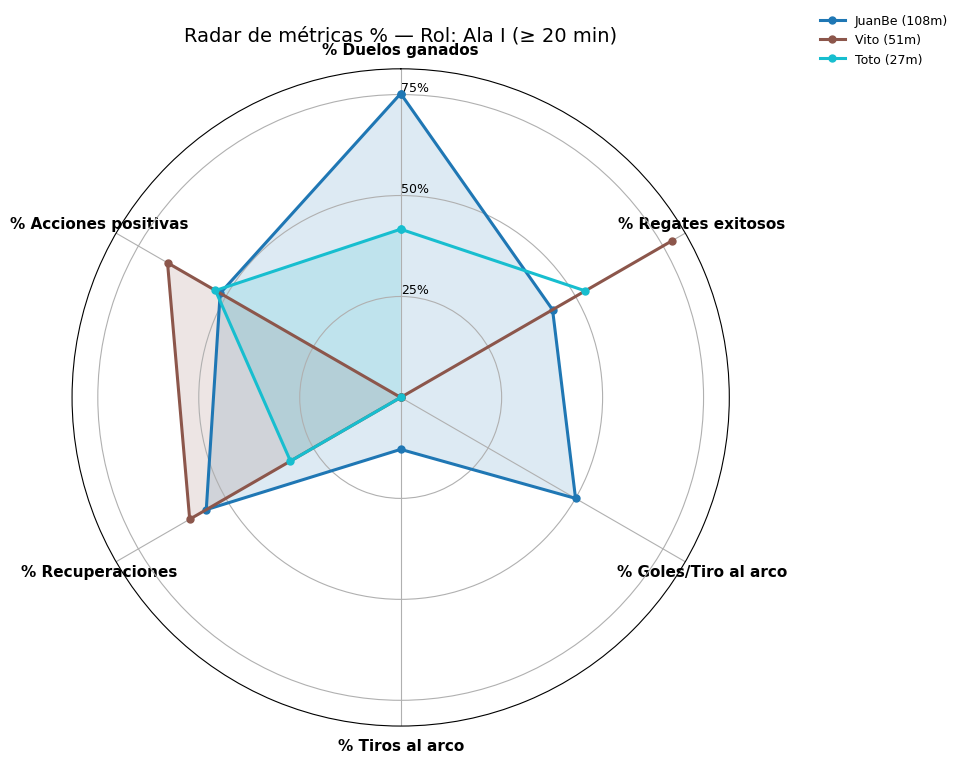

✅ Radar generado: /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/radar_pct_ala_i.png


In [13]:
# ==== Radar de métricas % con colores diferenciados + tabla CSV ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# 0) Montar Drive (Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

# --- paths ---
MATRIX_FINAL_POR_ROL = "/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/matrix_final_por_rol.csv"
MATRIX_POR_ROL       = "/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/_matrix_por_rol.csv"
MINUTOS_ROL          = "/content/drive/MyDrive/Sport Data Campus/TFM/Minutos/_salidas_minutos/minutos_por_partido_rol.csv"
OUT_DIR              = "/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/"

# --- configuración ---
ROL_OBJETIVO = "Ala I"   # <-- cambiá el rol acá
MINUTOS_MIN  = 20.0      # minutos totales mínimos en ese rol

# Métricas pedidas (todas %). Mapeo "etiqueta del radar" -> "columna en CSV"
METRIC_MAP = {
    "% Duelos ganados":        "Duelos - % Ganados",
    "% Regates exitosos":      "% Regates Exitosos",
    "% Goles/Tiro al arco":    "Tiros - % Goles/Tiro al arco",
    "% Tiros al arco":         "Tiros - % al arco",
    "% Recuperaciones":        "% Recuperaciones",
    "% Acciones positivas":    "% Acciones Positivas",
}
METRICS = list(METRIC_MAP.keys())

# --- cargar data ---
df_final  = pd.read_csv(MATRIX_FINAL_POR_ROL)
df_matrix = pd.read_csv(MATRIX_POR_ROL)
df_mins   = pd.read_csv(MINUTOS_ROL)

for d in (df_final, df_matrix, df_mins):
    d["rol"] = d["rol"].astype(str)

# 1) Partidos válidos (intersección por jugador/rol/partido)
valid = pd.merge(
    df_matrix[["partido_id","fecha","rival","jugador","rol"]],
    df_mins[["partido_id","fecha","rival","nombre","rol","minutos"]],
    left_on=["partido_id","fecha","rival","jugador","rol"],
    right_on=["partido_id","fecha","rival","nombre","rol"],
    how="inner"
).drop(columns=["nombre"])

# 2) Minutos totales por jugador/rol y filtro por rol+minutos
mins_por_rol = valid.groupby(["jugador","rol"], as_index=False)["minutos"].sum()
mins_ok = mins_por_rol[
    (mins_por_rol["rol"].str.strip().str.lower() == ROL_OBJETIVO.lower()) &
    (mins_por_rol["minutos"] >= MINUTOS_MIN)
]

# 3) Unir con la matriz final (promedios ya calculados)
plot_df = pd.merge(
    df_final[df_final["rol"].str.strip().str.lower() == ROL_OBJETIVO.lower()],
    mins_ok[["jugador","rol","minutos"]],
    on=["jugador","rol"],
    how="inner"
).copy()

# 4) Armar dataset solo con métricas presentes
missing = [METRIC_MAP[m] for m in METRICS if METRIC_MAP[m] not in plot_df.columns]
if missing:
    print("⚠️ Faltan columnas en matrix_final_por_rol.csv:", missing)

labels = [m for m in METRICS if METRIC_MAP[m] in plot_df.columns]
cols_to_take = ["jugador","rol","minutos"] + [METRIC_MAP[m] for m in labels]
plot_df = plot_df[cols_to_take].copy()

# 5) Asegurar numérico y llevar % a 0–1 para graficar
for m in labels:
    c = METRIC_MAP[m]
    plot_df[c] = pd.to_numeric(plot_df[c], errors="coerce").clip(lower=0, upper=100) / 100.0

# 6) Orden por minutos (desc) y tabla CSV con valores visibles (en % 0–100)
plot_df = plot_df.sort_values("minutos", ascending=False).reset_index(drop=True)

tabla = plot_df[["jugador","minutos"] + [METRIC_MAP[m] for m in labels]].copy()
for m in labels:
    c = METRIC_MAP[m]
    tabla[c] = (tabla[c] * 100).round(2)

csv_out = OUT_DIR + f"tabla_radar_pct_{ROL_OBJETIVO.lower().replace(' ','_')}.csv"
tabla.to_csv(csv_out, index=False)
print("📄 Tabla CSV guardada:", csv_out)
print("\nVista previa:")
print(tabla.to_string(index=False))

# 7) RADAR — colores bien diferenciados (matplotlib tab10/tab20)
N = len(labels)
if N == 0 or plot_df.empty:
    raise ValueError("No hay métricas/filas para graficar con el filtro actual.")

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi/2)
ax.set_theta_direction(-1)

# etiquetas de ejes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11, fontweight="bold")

# anillos 0–1 (equivalen a 0%–100%)
ax.set_rlabel_position(0)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["25%","50%","75%","100%"], fontsize=9)

# paleta: si hay >10 jugadores, usamos tab20; si >20, recicla tonos
n_series = len(plot_df)
if n_series <= 10:
    colors = plt.cm.tab10(np.linspace(0, 1, n_series))
else:
    colors = plt.cm.tab20(np.linspace(0, 1, min(n_series,20)))

# trazar cada jugador con color propio
for i, (_, row) in enumerate(plot_df.iterrows()):
    vals = [row[METRIC_MAP[m]] for m in labels]
    vals += vals[:1]
    color = colors[i % len(colors)]
    ax.plot(angles, vals, linewidth=2.2, marker="o", markersize=5,
            color=color, label=f"{row['jugador']} ({int(round(row['minutos']))}m)")
    ax.fill(angles, vals, alpha=0.15, color=color)

# leyenda clara fuera del gráfico
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1), fontsize=9, frameon=False)

plt.title(f"Radar de métricas % — Rol: {ROL_OBJETIVO} (≥ {int(MINUTOS_MIN)} min)", fontsize=14, pad=20)
plt.tight_layout()
out_png = OUT_DIR + f"radar_pct_{ROL_OBJETIVO.lower().replace(' ','_')}.png"
plt.savefig(out_png, dpi=150)
plt.show()
print("✅ Radar generado:", out_png)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📄 Tabla CSV guardada: /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/tabla_radar_pct_jugador_total.csv

Vista previa:
jugador  minutos  Duelos - % Ganados  % Regates Exitosos  Tiros - % Goles/Tiro al arco  Tiros - % al arco  % Recuperaciones  % Acciones Positivas
 JuanBe   238.50               53.74               33.39                         50.00               9.18             48.49                 49.12
  Zurdo   230.65               73.33               65.83                         33.33              39.39             51.42                 57.26
  Bruno   216.74               40.00               37.14                         50.00              31.62             41.85                 48.57
  Mateo   174.67               32.86               10.12                        100.00              37.50             31.62                 48.60


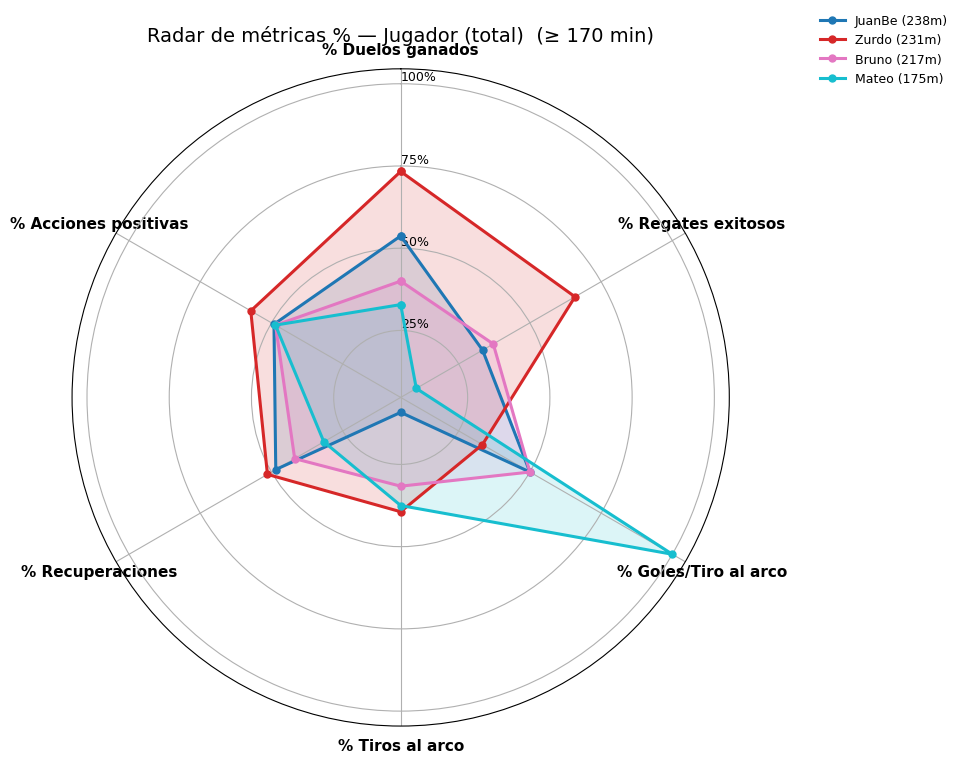

✅ Radar generado: /content/drive/MyDrive/Sport Data Campus/TFM/Matrix/radar_pct_jugador_total.png


In [16]:
# ==== Radar de métricas % por JUGADOR (total) + tabla CSV ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# 0) Montar Drive (Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

# --- paths ---
MATRIX_FINAL_POR_JUG = "/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/matrix_final_por_jugador.csv"
MATRIX_POR_ROL       = "/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/_matrix_por_rol.csv"  # para validar partidos
MINUTOS_TOTAL        = "/content/drive/MyDrive/Sport Data Campus/TFM/Minutos/_salidas_minutos/minutos_por_partido_total.csv"
OUT_DIR              = "/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/"

# --- configuración ---
MINUTOS_MIN  = 170.0  # minutos totales mínimos (sumando partidos válidos) por jugador

# Métricas pedidas (todas %). Mapeo "etiqueta del radar" -> "columna en CSV"
METRIC_MAP = {
    "% Duelos ganados":        "Duelos - % Ganados",
    "% Regates exitosos":      "% Regates Exitosos",
    "% Goles/Tiro al arco":    "Tiros - % Goles/Tiro al arco",
    "% Tiros al arco":         "Tiros - % al arco",
    "% Recuperaciones":        "% Recuperaciones",
    "% Acciones positivas":    "% Acciones Positivas",
}
METRICS = list(METRIC_MAP.keys())

# --- cargar datasets ---
df_final_j = pd.read_csv(MATRIX_FINAL_POR_JUG)         # promedios por jugador (totales)
df_matrix  = pd.read_csv(MATRIX_POR_ROL)               # matrix por rol, para detectar partidos válidos
df_mintot  = pd.read_csv(MINUTOS_TOTAL)                # minutos por jugador y partido

# Normalizar tipos
for d in (df_final_j, df_matrix, df_mintot):
    if "jugador" in d.columns:
        d["jugador"] = d["jugador"].astype(str)
    if "nombre" in d.columns:
        d["nombre"] = d["nombre"].astype(str)

# === Determinar PARTIDOS VÁLIDOS por JUGADOR (intersección Matrix x Minutos) ===
valid = pd.merge(
    df_matrix[["partido_id","fecha","rival","jugador"]],
    df_mintot[["partido_id","fecha","rival","nombre","minutos"]],
    left_on=["partido_id","fecha","rival","jugador"],
    right_on=["partido_id","fecha","rival","nombre"],
    how="inner"
).drop(columns=["nombre"])

# Minutos totales válidos por jugador (sumando todos los roles/partidos)
mins_ok = valid.groupby(["jugador"], as_index=False)["minutos"].sum()
mins_ok = mins_ok[mins_ok["minutos"] >= MINUTOS_MIN].copy()

# Unir con la matriz final por jugador (promedios ya calculados)
plot_df = pd.merge(
    df_final_j,
    mins_ok[["jugador","minutos"]],
    on="jugador",
    how="inner"
).copy()

# Verificar columnas presentes
missing = [METRIC_MAP[m] for m in METRICS if METRIC_MAP[m] not in plot_df.columns]
if missing:
    print("⚠️ Faltan columnas en matrix_final_por_jugador.csv:", missing)

# Dataset final con las métricas presentes
labels = [m for m in METRICS if METRIC_MAP[m] in plot_df.columns]
cols_to_take = ["jugador","minutos"] + [METRIC_MAP[m] for m in labels]
plot_df = plot_df[cols_to_take].copy()

# Asegurar numérico y llevar % a 0–1 para graficar
for m in labels:
    c = METRIC_MAP[m]
    plot_df[c] = pd.to_numeric(plot_df[c], errors="coerce").clip(lower=0, upper=100) / 100.0

# Orden por minutos (desc)
plot_df = plot_df.sort_values("minutos", ascending=False).reset_index(drop=True)

# === Guardar TABLA CSV con valores en % (0–100, 2 decimales) ===
tabla = plot_df[["jugador","minutos"] + [METRIC_MAP[m] for m in labels]].copy()
for m in labels:
    c = METRIC_MAP[m]
    tabla[c] = (tabla[c] * 100).round(2)

csv_out = OUT_DIR + "tabla_radar_pct_jugador_total.csv"
tabla.to_csv(csv_out, index=False)
print("📄 Tabla CSV guardada:", csv_out)
print("\nVista previa:")
print(tabla.to_string(index=False))

# === RADAR ===
N = len(labels)
if N == 0 or plot_df.empty:
    raise ValueError("No hay métricas/filas para graficar con el filtro actual.")

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi/2)
ax.set_theta_direction(-1)

# etiquetas de ejes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11, fontweight="bold")

# anillos 0–1 (equivalen a 0%–100%)
ax.set_rlabel_position(0)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["25%","50%","75%","100%"], fontsize=9)

# paleta: tab10/tab20 bien contrastante
n_series = len(plot_df)
if n_series <= 10:
    colors = plt.cm.tab10(np.linspace(0, 1, n_series))
else:
    colors = plt.cm.tab20(np.linspace(0, 1, min(n_series,20)))

# trazar cada jugador con color propio
for i, (_, row) in enumerate(plot_df.iterrows()):
    vals = [row[METRIC_MAP[m]] for m in labels]
    vals += vals[:1]
    color = colors[i % len(colors)]
    ax.plot(angles, vals, linewidth=2.2, marker="o", markersize=5,
            color=color, label=f"{row['jugador']} ({int(round(row['minutos']))}m)")
    ax.fill(angles, vals, alpha=0.15, color=color)

# leyenda clara
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1), fontsize=9, frameon=False)

plt.title(f"Radar de métricas % — Jugador (total)  (≥ {int(MINUTOS_MIN)} min)", fontsize=14, pad=20)
plt.tight_layout()
out_png = OUT_DIR + "radar_pct_jugador_total.png"
plt.savefig(out_png, dpi=150)
plt.show()
print("✅ Radar generado:", out_png)


In [8]:
# === Detalle por PARTIDO para un jugador/rol/métrica ===
import pandas as pd
import numpy as np
import unicodedata as ud
import re

# --- CONFIGURA ACÁ ---
JUGADOR = "Brandon"             # nombre exacto como aparece en _matrix_por_rol.csv
ROL      = "Arq"             # ej: "Ala I", "Ala D", "Cierre", "Pivot", "Arq"
METRICA  = "Pase Progresivo Frontal cPie"  # ej: "Tiro Hecho", "% Acciones Positivas", etc.

# --- paths ---
MATRIX_POR_ROL = "/content/drive/MyDrive/Sport Data Campus/TFM/Matrix/_matrix_por_rol.csv"
MINUTOS_ROL    = "/content/drive/MyDrive/Sport Data Campus/TFM/Minutos/_salidas_minutos/minutos_por_partido_rol.csv"

# --- helpers ---
def norm_txt(s: str) -> str:
    s = str(s)
    s = ud.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    return re.sub(r"\s+", " ", s.strip().lower())

# Cargar
df_mat = pd.read_csv(MATRIX_POR_ROL)
df_min = pd.read_csv(MINUTOS_ROL)

# Filtro jugador/rol (case-insensitive, tolerante a tildes)
df_mat["_jug_norm"] = df_mat["jugador"].map(norm_txt)
df_mat["_rol_norm"] = df_mat["rol"].map(norm_txt)
jug_norm = norm_txt(JUGADOR)
rol_norm = norm_txt(ROL)
dfm = df_mat[(df_mat["_jug_norm"] == jug_norm) & (df_mat["_rol_norm"] == rol_norm)].copy()

if dfm.empty:
    raise ValueError(f"No encontré filas para jugador='{JUGADOR}' y rol='{ROL}' en {MATRIX_POR_ROL}")

# Asegurar métrica (permitir buscar por normalizado si no coincide exacto)
cols_norm_map = {norm_txt(c): c for c in dfm.columns}
metrica_col = cols_norm_map.get(norm_txt(METRICA))
if not metrica_col:
    similares = [c for c in dfm.columns if norm_txt(METRICA) in norm_txt(c)]
    raise ValueError(f"No encontré la métrica '{METRICA}'. Sugerencias: {similares[:10]}")

# Unir SOLO partidos válidos (presentes en ambos archivos), y minutos de ese rol
df_min["_jug_norm"] = df_min["nombre"].map(norm_txt)
df_min["_rol_norm"] = df_min["rol"].map(norm_txt)

valid = pd.merge(
    dfm[["partido_id","fecha","rival","jugador","rol", metrica_col]],
    df_min[["partido_id","fecha","rival","nombre","rol","minutos","_jug_norm","_rol_norm"]],
    left_on=["partido_id","fecha","rival","jugador","rol"],
    right_on=["partido_id","fecha","rival","nombre","rol"],
    how="inner"
)

if valid.empty:
    raise ValueError("No hay partidos en común entre Matrix y Minutos para ese jugador/rol.")

# Preparar cálculo por partido
calc = valid[["partido_id","fecha","rival","jugador","rol","minutos", metrica_col]].copy()
calc.rename(columns={metrica_col: "valor_crudo"}, inplace=True)

# Asegurar tipos numéricos
calc["minutos"] = pd.to_numeric(calc["minutos"], errors="coerce")
calc["valor_crudo"] = pd.to_numeric(calc["valor_crudo"], errors="coerce").fillna(0)

# Detectar si es porcentaje
es_porcentaje = ("%" in METRICA) or ("%" in metrica_col)

# Normalización a 40' solo si NO es %
if not es_porcentaje:
    calc["valor_40min"] = calc.apply(lambda r: (r["valor_crudo"] * (40.0 / r["minutos"])) if r["minutos"] and r["minutos"] > 0 else np.nan, axis=1)
else:
    calc["valor_40min"] = np.nan  # no aplica

# Orden lindo
calc = calc.sort_values(["fecha","partido_id"]).reset_index(drop=True)

# Mostrar tabla por partido
print(f"\n=== Detalle por partido — {JUGADOR} ({ROL}) — Métrica: {METRICA} ===")
cols_show = ["partido_id","fecha","rival","minutos","valor_crudo"] + (["valor_40min"] if not es_porcentaje else [])
print(calc[cols_show].to_string(index=False))

# Resumen
partidos = calc.shape[0]
min_tot = calc["minutos"].sum()
sum_crudo = calc["valor_crudo"].sum()
prom_crudo = calc["valor_crudo"].mean()

if not es_porcentaje:
    prom_40 = calc["valor_40min"].mean()
    print("\n--- RESUMEN ---")
    print(f"Partidos válidos: {partidos}")
    print(f"Minutos totales en {ROL}: {min_tot:.1f}")
    print(f"Suma '{METRICA}' (crudo): {sum_crudo:.2f}")
    print(f"Promedio por partido (crudo): {prom_crudo:.2f}")
    print(f"Promedio normalizado a 40': {prom_40:.2f}")
else:
    print("\n--- RESUMEN ---")
    print(f"Partidos válidos: {partidos}")
    print(f"Minutos totales en {ROL}: {min_tot:.1f}")
    print(f"Promedio de '{METRICA}': {prom_crudo:.2f}")  # para % ya es comparables sin normalizar



=== Detalle por partido — Brandon (Arq) — Métrica: Pase Progresivo Frontal cPie ===
      partido_id  fecha         rival  minutos  valor_crudo  valor_40min
F2_Independiente      2 Independiente    20.39            1     1.961746
      F6_Pinocho      6       Pinocho    17.43            1     2.294894
   F7_Miriñaque      7    Miriñaque    10.36            0     0.000000

--- RESUMEN ---
Partidos válidos: 3
Minutos totales en Arq: 48.2
Suma 'Pase Progresivo Frontal cPie' (crudo): 2.00
Promedio por partido (crudo): 0.67
Promedio normalizado a 40': 1.42
